# Natural Computing - Assignment 2 - Swarm Intelligence
## Exercise 3 - PSO
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

This file contains our solution to exercise 3 of the "Swarm Intelligence" assignment of the Natural Computing course.

### Imports

In [1]:
from sklearn import datasets
import numpy as np
import random
import pdb
import matplotlib.pyplot as plt 
import itertools
from mpl_toolkits.mplot3d import Axes3D 

### Utility functions

#### Euclidean distance

In [2]:
def euclidean_distance(point_one, point_two):
    # Compute Euclidean distance between two points (dimensions need to match)
    return np.sqrt(np.sum((point_one-point_two)**2))

#### Quantization error

In [3]:
def quantization_error(centroids, datapoints):
    # Retrieve number of clusters
    n_clusters = len(centroids)
    
    # Initialize dictionary for cluster distance arrays
    clusters = {i:[] for i in range(n_clusters)}

    # Iterate through all datapoints
    for datapoint in datapoints:
        # Compute Euclidean distance between this datapoint and all centroids
        distances = [euclidean_distance(centroid,datapoint) for centroid in centroids]
        
        # Store distance to closest centroid in corresponding array (so that we don't need to compute it twice)
        clusters[np.argmin(distances)].append(min(distances))

    # Compute quantization error (using a simplified but equivalent version of the formula in the paper)
    errors_per_cluster = [sum(cluster)/len(cluster) if cluster else 0 for cluster in clusters.values()]
    error = sum(errors_per_cluster)/n_clusters
    
    # Return the computed quantization error
    return error

#### Extracting clusters

In [4]:
def extract_clusters(centroids, datapoints):
    # Retrieve number of clusters
    n_clusters = len(centroids)

    # Initialize dictionary for cluster arrays
    clusters = {i:[] for i in range(n_clusters)}
    
    # Iterate through all datapoints
    for datapoint in datapoints:
        # Compute Euclidean distance between this datapoint and all centroids
        distances = [euclidean_distance(centroid,datapoint) for centroid in centroids]

        # Store datapoint in cluster array corresponding to nearest centroid
        clusters[np.argmin(distances)].append(datapoint)
    
    # Return the computed clusters
    return clusters

### PSO clustering algorithm

In [5]:
def PSO_clustering(n_clusters, n_particles, n_iterations, datapoints, 
                   omega=0.7298, alpha_1=1.49618, alpha_2=1.49618, verbose=False):
    # Compute number of dimensions
    n_dims = datapoints.shape[1]
    
    # Initialize particles, using random datapoints as the centroids (to ensure reasonable initial centroids)
    particles, speeds = [], []
    for n in range(n_particles):
        # Select indices of random datapoints to use as centroids
        seed_idxs = np.random.permutation(range(datapoints.shape[0]))[:n_clusters]
        # Create the particle
        particle = datapoints[seed_idxs]
        # Add the particle to the list of particles
        particles.append(particle)
        # Add an initial speed of 0 to the list of speeds
        speeds.append(np.zeros(particle.shape))
    
    # Initialize local & global bests
    local_bests = [([],float('inf')) for particle in particles]
    global_best = ([],float('inf'))
    
    # Perform iterations until termination
    for iteration in range(n_iterations):
        # Print iteration number if verbose is true
        if verbose:
            print(f"PSO iteration {iteration}")
        
        # For each particle:
        for i,particle in enumerate(particles):
            # Compute fitness (quantization error)
            fitness = quantization_error(particle, datapoints)
            # Update local best
            if fitness < local_bests[i][1]:
                local_bests[i] = (particle, fitness)
        
        # Update global best
        best_in_iteration = np.argmin([local_best[1] for local_best in local_bests])
        if local_bests[best_in_iteration][1] < global_best[1]:
            global_best = local_bests[best_in_iteration]
        
        # Update particle positions
        for i in range(n_particles):
            r_1 = np.random.uniform(0,1,particle.shape)
            r_2 = np.random.uniform(0,1,particle.shape)
            speeds[i] = omega*speeds[i] \
                      + np.multiply(alpha_1*r_1, local_bests[i][0]-particles[i]) \
                      + np.multiply(alpha_2*r_2, global_best[0]-particles[i])
            particles[i] = particles[i] + speeds[i]
    
    # Return the global best
    return global_best[0] 

### K-means clustering algorithm

In [6]:
def KMeans_clustering(n_clusters, max_iter, n_init, datapoints, verbose=False):
    # Compute number of dimensions
    n_dims = datapoints.shape[1]
    
    # Initialize storage for best solution found
    best_solution = ([], float('inf'))
    
    # For each initialization, perform a single k-means clustering iteration and update the best solution
    for init in range(n_init):
        # Print initialization number if verbose is true
        if verbose:
            print(f"KMeans initialization {init}")
            
        # Initialize cluster centroids, using random datapoints (to ensure reasonable initial centroids)
        seed_idxs = np.random.permutation(range(datapoints.shape[0]))[:n_clusters]
        centroids = datapoints[seed_idxs]

        # For each iteration, do the following:
        for iteration in range(max_iter):
            # Initialize dictionary for cluster arrays
            clusters = {i:[] for i in range(n_clusters)}
        
            # Assign datapoints to cluster corresponding to closest centroid
            for datapoint in datapoints:
                distances = [euclidean_distance(centroid,datapoint) for centroid in centroids]
                clusters[np.argmin(distances)].append(datapoint)
            
            # Recalculate cluster centroids (for non-empty clusters)
            for cluster_index in range(n_clusters):
                if clusters[cluster_index]:
                    centroids[cluster_index] = np.sum(clusters[cluster_index], axis=0) / len(clusters[cluster_index]) 
                    
        # Update best solution if there is no best solution yet or the new solution is better
        error = quantization_error(centroids, datapoints)
        if error < best_solution[1]:
            best_solution = (centroids, error)
        
    # Return the best solution found
    return best_solution[0]

### Loading datasets

#### Artificial dataset I 
(as described [here](https://scholar.google.nl/scholar?hl=nl&as_sdt=0%2C5&q=Van+der+Merwe%2C+D.+W.%2C+and+Andries+Petrus+Engelbrecht.+%22Data+clustering+using+particle+swarm+optimization%22&btnG=))

In [7]:
artificial_dataset_size = 400

artificial_X = np.array([(random.uniform(-1,1), random.uniform(-1,1)) for i in range(artificial_dataset_size)])
artificial_Y = np.array([int((z_1 >= 0.7) or ((z_1 <= 0.3) and (z_2 >= -0.2 - z_1))) for (z_1,z_2) in artificial_X])
artificial_n_clusters = len(np.unique(artificial_Y))

#### Iris dataset

In [8]:
iris = datasets.load_iris()

iris_X = iris.data
iris_Y = iris.target
iris_n_clusters = len(np.unique(iris_Y))

### Testing

In [9]:
n_trials = 30
n_particles = 10
n_initializations = 10
n_iterations = 100

In [10]:
def test_PSO_KMeans(dataset, n_trials, n_clusters, n_particles, n_iterations, verbose=False):
    # Initialize lists of errors
    PSO_errors = []
    KMeans_errors = []
    
    # For each trial, do:
    for trial in range(n_trials):
        # Print the trial number if verbose is true
        if verbose:
            print(f"Testing trial {trial}")
        
        # Solve using PSO clustering and compute the resulting quantization error
        PSO_solution = PSO_clustering(n_clusters, n_particles, n_iterations, dataset, verbose=verbose)
        PSO_errors.append(quantization_error(PSO_solution, dataset))
        
        # Solve using K-means clustering and compute the resulting quantization error
        KMeans_solution = KMeans_clustering(n_clusters, n_iterations, n_initializations, dataset, verbose=verbose)
        KMeans_errors.append(quantization_error(KMeans_solution, dataset))

    # Print the results
    if verbose:
        print("")
    print(f"Average PSO quantization error over 30 simulations: " \
          f"{np.average(PSO_errors)} ± {np.std(PSO_errors)}")
    print(f"Average KMeans quantization error over 30 simulations: " \
          f"{np.average(KMeans_errors)} ± {np.std(KMeans_errors)}")

#### Artificial dataset 1

In [11]:
test_PSO_KMeans(artificial_X, n_trials, artificial_n_clusters, n_particles, n_iterations, True)

Testing trial 0
PSO iteration 0
PSO iteration 1
PSO iteration 2
PSO iteration 3
PSO iteration 4
PSO iteration 5
PSO iteration 6
PSO iteration 7
PSO iteration 8
PSO iteration 9
PSO iteration 10
PSO iteration 11
PSO iteration 12
PSO iteration 13
PSO iteration 14
PSO iteration 15
PSO iteration 16
PSO iteration 17
PSO iteration 18
PSO iteration 19
PSO iteration 20
PSO iteration 21
PSO iteration 22
PSO iteration 23
PSO iteration 24
PSO iteration 25
PSO iteration 26
PSO iteration 27
PSO iteration 28
PSO iteration 29
PSO iteration 30
PSO iteration 31
PSO iteration 32
PSO iteration 33
PSO iteration 34
PSO iteration 35
PSO iteration 36
PSO iteration 37
PSO iteration 38
PSO iteration 39
PSO iteration 40
PSO iteration 41
PSO iteration 42
PSO iteration 43
PSO iteration 44
PSO iteration 45
PSO iteration 46
PSO iteration 47
PSO iteration 48
PSO iteration 49
PSO iteration 50
PSO iteration 51
PSO iteration 52
PSO iteration 53
PSO iteration 54
PSO iteration 55
PSO iteration 56
PSO iteration 57
PSO iter

PSO iteration 27
PSO iteration 28
PSO iteration 29
PSO iteration 30
PSO iteration 31
PSO iteration 32
PSO iteration 33
PSO iteration 34
PSO iteration 35
PSO iteration 36
PSO iteration 37
PSO iteration 38
PSO iteration 39
PSO iteration 40
PSO iteration 41
PSO iteration 42
PSO iteration 43
PSO iteration 44
PSO iteration 45
PSO iteration 46
PSO iteration 47
PSO iteration 48
PSO iteration 49
PSO iteration 50
PSO iteration 51
PSO iteration 52
PSO iteration 53
PSO iteration 54
PSO iteration 55
PSO iteration 56
PSO iteration 57
PSO iteration 58
PSO iteration 59
PSO iteration 60
PSO iteration 61
PSO iteration 62
PSO iteration 63
PSO iteration 64
PSO iteration 65
PSO iteration 66
PSO iteration 67
PSO iteration 68
PSO iteration 69
PSO iteration 70
PSO iteration 71
PSO iteration 72
PSO iteration 73
PSO iteration 74
PSO iteration 75
PSO iteration 76
PSO iteration 77
PSO iteration 78
PSO iteration 79
PSO iteration 80
PSO iteration 81
PSO iteration 82
PSO iteration 83
PSO iteration 84
PSO iteration 

PSO iteration 52
PSO iteration 53
PSO iteration 54
PSO iteration 55
PSO iteration 56
PSO iteration 57
PSO iteration 58
PSO iteration 59
PSO iteration 60
PSO iteration 61
PSO iteration 62
PSO iteration 63
PSO iteration 64
PSO iteration 65
PSO iteration 66
PSO iteration 67
PSO iteration 68
PSO iteration 69
PSO iteration 70
PSO iteration 71
PSO iteration 72
PSO iteration 73
PSO iteration 74
PSO iteration 75
PSO iteration 76
PSO iteration 77
PSO iteration 78
PSO iteration 79
PSO iteration 80
PSO iteration 81
PSO iteration 82
PSO iteration 83
PSO iteration 84
PSO iteration 85
PSO iteration 86
PSO iteration 87
PSO iteration 88
PSO iteration 89
PSO iteration 90
PSO iteration 91
PSO iteration 92
PSO iteration 93
PSO iteration 94
PSO iteration 95
PSO iteration 96
PSO iteration 97
PSO iteration 98
PSO iteration 99
KMeans initialization 0
KMeans initialization 1
KMeans initialization 2
KMeans initialization 3
KMeans initialization 4
KMeans initialization 5
KMeans initialization 6
KMeans initializ

PSO iteration 78
PSO iteration 79
PSO iteration 80
PSO iteration 81
PSO iteration 82
PSO iteration 83
PSO iteration 84
PSO iteration 85
PSO iteration 86
PSO iteration 87
PSO iteration 88
PSO iteration 89
PSO iteration 90
PSO iteration 91
PSO iteration 92
PSO iteration 93
PSO iteration 94
PSO iteration 95
PSO iteration 96
PSO iteration 97
PSO iteration 98
PSO iteration 99
KMeans initialization 0
KMeans initialization 1
KMeans initialization 2
KMeans initialization 3
KMeans initialization 4
KMeans initialization 5
KMeans initialization 6
KMeans initialization 7
KMeans initialization 8
KMeans initialization 9
Testing trial 13
PSO iteration 0
PSO iteration 1
PSO iteration 2
PSO iteration 3
PSO iteration 4
PSO iteration 5
PSO iteration 6
PSO iteration 7
PSO iteration 8
PSO iteration 9
PSO iteration 10
PSO iteration 11
PSO iteration 12
PSO iteration 13
PSO iteration 14
PSO iteration 15
PSO iteration 16
PSO iteration 17
PSO iteration 18
PSO iteration 19
PSO iteration 20
PSO iteration 21
PSO i

KMeans initialization 2
KMeans initialization 3
KMeans initialization 4
KMeans initialization 5
KMeans initialization 6
KMeans initialization 7
KMeans initialization 8
KMeans initialization 9
Testing trial 17
PSO iteration 0
PSO iteration 1
PSO iteration 2
PSO iteration 3
PSO iteration 4
PSO iteration 5
PSO iteration 6
PSO iteration 7
PSO iteration 8
PSO iteration 9
PSO iteration 10
PSO iteration 11
PSO iteration 12
PSO iteration 13
PSO iteration 14
PSO iteration 15
PSO iteration 16
PSO iteration 17
PSO iteration 18
PSO iteration 19
PSO iteration 20
PSO iteration 21
PSO iteration 22
PSO iteration 23
PSO iteration 24
PSO iteration 25
PSO iteration 26
PSO iteration 27
PSO iteration 28
PSO iteration 29
PSO iteration 30
PSO iteration 31
PSO iteration 32
PSO iteration 33
PSO iteration 34
PSO iteration 35
PSO iteration 36
PSO iteration 37
PSO iteration 38
PSO iteration 39
PSO iteration 40
PSO iteration 41
PSO iteration 42
PSO iteration 43
PSO iteration 44
PSO iteration 45
PSO iteration 46
PS

PSO iteration 13
PSO iteration 14
PSO iteration 15
PSO iteration 16
PSO iteration 17
PSO iteration 18
PSO iteration 19
PSO iteration 20
PSO iteration 21
PSO iteration 22
PSO iteration 23
PSO iteration 24
PSO iteration 25
PSO iteration 26
PSO iteration 27
PSO iteration 28
PSO iteration 29
PSO iteration 30
PSO iteration 31
PSO iteration 32
PSO iteration 33
PSO iteration 34
PSO iteration 35
PSO iteration 36
PSO iteration 37
PSO iteration 38
PSO iteration 39
PSO iteration 40
PSO iteration 41
PSO iteration 42
PSO iteration 43
PSO iteration 44
PSO iteration 45
PSO iteration 46
PSO iteration 47
PSO iteration 48
PSO iteration 49
PSO iteration 50
PSO iteration 51
PSO iteration 52
PSO iteration 53
PSO iteration 54
PSO iteration 55
PSO iteration 56
PSO iteration 57
PSO iteration 58
PSO iteration 59
PSO iteration 60
PSO iteration 61
PSO iteration 62
PSO iteration 63
PSO iteration 64
PSO iteration 65
PSO iteration 66
PSO iteration 67
PSO iteration 68
PSO iteration 69
PSO iteration 70
PSO iteration 

PSO iteration 37
PSO iteration 38
PSO iteration 39
PSO iteration 40
PSO iteration 41
PSO iteration 42
PSO iteration 43
PSO iteration 44
PSO iteration 45
PSO iteration 46
PSO iteration 47
PSO iteration 48
PSO iteration 49
PSO iteration 50
PSO iteration 51
PSO iteration 52
PSO iteration 53
PSO iteration 54
PSO iteration 55
PSO iteration 56
PSO iteration 57
PSO iteration 58
PSO iteration 59
PSO iteration 60
PSO iteration 61
PSO iteration 62
PSO iteration 63
PSO iteration 64
PSO iteration 65
PSO iteration 66
PSO iteration 67
PSO iteration 68
PSO iteration 69
PSO iteration 70
PSO iteration 71
PSO iteration 72
PSO iteration 73
PSO iteration 74
PSO iteration 75
PSO iteration 76
PSO iteration 77
PSO iteration 78
PSO iteration 79
PSO iteration 80
PSO iteration 81
PSO iteration 82
PSO iteration 83
PSO iteration 84
PSO iteration 85
PSO iteration 86
PSO iteration 87
PSO iteration 88
PSO iteration 89
PSO iteration 90
PSO iteration 91
PSO iteration 92
PSO iteration 93
PSO iteration 94
PSO iteration 

PSO iteration 60
PSO iteration 61
PSO iteration 62
PSO iteration 63
PSO iteration 64
PSO iteration 65
PSO iteration 66
PSO iteration 67
PSO iteration 68
PSO iteration 69
PSO iteration 70
PSO iteration 71
PSO iteration 72
PSO iteration 73
PSO iteration 74
PSO iteration 75
PSO iteration 76
PSO iteration 77
PSO iteration 78
PSO iteration 79
PSO iteration 80
PSO iteration 81
PSO iteration 82
PSO iteration 83
PSO iteration 84
PSO iteration 85
PSO iteration 86
PSO iteration 87
PSO iteration 88
PSO iteration 89
PSO iteration 90
PSO iteration 91
PSO iteration 92
PSO iteration 93
PSO iteration 94
PSO iteration 95
PSO iteration 96
PSO iteration 97
PSO iteration 98
PSO iteration 99
KMeans initialization 0
KMeans initialization 1
KMeans initialization 2
KMeans initialization 3
KMeans initialization 4
KMeans initialization 5
KMeans initialization 6
KMeans initialization 7
KMeans initialization 8
KMeans initialization 9

Average PSO quantization error over 30 simulations: 0.42806332320571794 ± 0.076

#### Iris dataset

In [12]:
test_PSO_KMeans(iris_X, n_trials, iris_n_clusters, n_particles, n_iterations, True)   

Testing trial 0
PSO iteration 0
PSO iteration 1
PSO iteration 2
PSO iteration 3
PSO iteration 4
PSO iteration 5
PSO iteration 6
PSO iteration 7
PSO iteration 8
PSO iteration 9
PSO iteration 10
PSO iteration 11
PSO iteration 12
PSO iteration 13
PSO iteration 14
PSO iteration 15
PSO iteration 16
PSO iteration 17
PSO iteration 18
PSO iteration 19
PSO iteration 20
PSO iteration 21
PSO iteration 22
PSO iteration 23
PSO iteration 24
PSO iteration 25
PSO iteration 26
PSO iteration 27
PSO iteration 28
PSO iteration 29
PSO iteration 30
PSO iteration 31
PSO iteration 32
PSO iteration 33
PSO iteration 34
PSO iteration 35
PSO iteration 36
PSO iteration 37
PSO iteration 38
PSO iteration 39
PSO iteration 40
PSO iteration 41
PSO iteration 42
PSO iteration 43
PSO iteration 44
PSO iteration 45
PSO iteration 46
PSO iteration 47
PSO iteration 48
PSO iteration 49
PSO iteration 50
PSO iteration 51
PSO iteration 52
PSO iteration 53
PSO iteration 54
PSO iteration 55
PSO iteration 56
PSO iteration 57
PSO iter

PSO iteration 27
PSO iteration 28
PSO iteration 29
PSO iteration 30
PSO iteration 31
PSO iteration 32
PSO iteration 33
PSO iteration 34
PSO iteration 35
PSO iteration 36
PSO iteration 37
PSO iteration 38
PSO iteration 39
PSO iteration 40
PSO iteration 41
PSO iteration 42
PSO iteration 43
PSO iteration 44
PSO iteration 45
PSO iteration 46
PSO iteration 47
PSO iteration 48
PSO iteration 49
PSO iteration 50
PSO iteration 51
PSO iteration 52
PSO iteration 53
PSO iteration 54
PSO iteration 55
PSO iteration 56
PSO iteration 57
PSO iteration 58
PSO iteration 59
PSO iteration 60
PSO iteration 61
PSO iteration 62
PSO iteration 63
PSO iteration 64
PSO iteration 65
PSO iteration 66
PSO iteration 67
PSO iteration 68
PSO iteration 69
PSO iteration 70
PSO iteration 71
PSO iteration 72
PSO iteration 73
PSO iteration 74
PSO iteration 75
PSO iteration 76
PSO iteration 77
PSO iteration 78
PSO iteration 79
PSO iteration 80
PSO iteration 81
PSO iteration 82
PSO iteration 83
PSO iteration 84
PSO iteration 

PSO iteration 57
PSO iteration 58
PSO iteration 59
PSO iteration 60
PSO iteration 61
PSO iteration 62
PSO iteration 63
PSO iteration 64
PSO iteration 65
PSO iteration 66
PSO iteration 67
PSO iteration 68
PSO iteration 69
PSO iteration 70
PSO iteration 71
PSO iteration 72
PSO iteration 73
PSO iteration 74
PSO iteration 75
PSO iteration 76
PSO iteration 77
PSO iteration 78
PSO iteration 79
PSO iteration 80
PSO iteration 81
PSO iteration 82
PSO iteration 83
PSO iteration 84
PSO iteration 85
PSO iteration 86
PSO iteration 87
PSO iteration 88
PSO iteration 89
PSO iteration 90
PSO iteration 91
PSO iteration 92
PSO iteration 93
PSO iteration 94
PSO iteration 95
PSO iteration 96
PSO iteration 97
PSO iteration 98
PSO iteration 99
KMeans initialization 0
KMeans initialization 1
KMeans initialization 2
KMeans initialization 3
KMeans initialization 4
KMeans initialization 5
KMeans initialization 6
KMeans initialization 7
KMeans initialization 8
KMeans initialization 9
Testing trial 9
PSO iteration

PSO iteration 83
PSO iteration 84
PSO iteration 85
PSO iteration 86
PSO iteration 87
PSO iteration 88
PSO iteration 89
PSO iteration 90
PSO iteration 91
PSO iteration 92
PSO iteration 93
PSO iteration 94
PSO iteration 95
PSO iteration 96
PSO iteration 97
PSO iteration 98
PSO iteration 99
KMeans initialization 0
KMeans initialization 1
KMeans initialization 2
KMeans initialization 3
KMeans initialization 4
KMeans initialization 5
KMeans initialization 6
KMeans initialization 7
KMeans initialization 8
KMeans initialization 9
Testing trial 13
PSO iteration 0
PSO iteration 1
PSO iteration 2
PSO iteration 3
PSO iteration 4
PSO iteration 5
PSO iteration 6
PSO iteration 7
PSO iteration 8
PSO iteration 9
PSO iteration 10
PSO iteration 11
PSO iteration 12
PSO iteration 13
PSO iteration 14
PSO iteration 15
PSO iteration 16
PSO iteration 17
PSO iteration 18
PSO iteration 19
PSO iteration 20
PSO iteration 21
PSO iteration 22
PSO iteration 23
PSO iteration 24
PSO iteration 25
PSO iteration 26
PSO i

KMeans initialization 5
KMeans initialization 6
KMeans initialization 7
KMeans initialization 8
KMeans initialization 9
Testing trial 17
PSO iteration 0
PSO iteration 1
PSO iteration 2
PSO iteration 3
PSO iteration 4
PSO iteration 5
PSO iteration 6
PSO iteration 7
PSO iteration 8
PSO iteration 9
PSO iteration 10
PSO iteration 11
PSO iteration 12
PSO iteration 13
PSO iteration 14
PSO iteration 15
PSO iteration 16
PSO iteration 17
PSO iteration 18
PSO iteration 19
PSO iteration 20
PSO iteration 21
PSO iteration 22
PSO iteration 23
PSO iteration 24
PSO iteration 25
PSO iteration 26
PSO iteration 27
PSO iteration 28
PSO iteration 29
PSO iteration 30
PSO iteration 31
PSO iteration 32
PSO iteration 33
PSO iteration 34
PSO iteration 35
PSO iteration 36
PSO iteration 37
PSO iteration 38
PSO iteration 39
PSO iteration 40
PSO iteration 41
PSO iteration 42
PSO iteration 43
PSO iteration 44
PSO iteration 45
PSO iteration 46
PSO iteration 47
PSO iteration 48
PSO iteration 49
PSO iteration 50
PSO it

PSO iteration 19
PSO iteration 20
PSO iteration 21
PSO iteration 22
PSO iteration 23
PSO iteration 24
PSO iteration 25
PSO iteration 26
PSO iteration 27
PSO iteration 28
PSO iteration 29
PSO iteration 30
PSO iteration 31
PSO iteration 32
PSO iteration 33
PSO iteration 34
PSO iteration 35
PSO iteration 36
PSO iteration 37
PSO iteration 38
PSO iteration 39
PSO iteration 40
PSO iteration 41
PSO iteration 42
PSO iteration 43
PSO iteration 44
PSO iteration 45
PSO iteration 46
PSO iteration 47
PSO iteration 48
PSO iteration 49
PSO iteration 50
PSO iteration 51
PSO iteration 52
PSO iteration 53
PSO iteration 54
PSO iteration 55
PSO iteration 56
PSO iteration 57
PSO iteration 58
PSO iteration 59
PSO iteration 60
PSO iteration 61
PSO iteration 62
PSO iteration 63
PSO iteration 64
PSO iteration 65
PSO iteration 66
PSO iteration 67
PSO iteration 68
PSO iteration 69
PSO iteration 70
PSO iteration 71
PSO iteration 72
PSO iteration 73
PSO iteration 74
PSO iteration 75
PSO iteration 76
PSO iteration 

PSO iteration 43
PSO iteration 44
PSO iteration 45
PSO iteration 46
PSO iteration 47
PSO iteration 48
PSO iteration 49
PSO iteration 50
PSO iteration 51
PSO iteration 52
PSO iteration 53
PSO iteration 54
PSO iteration 55
PSO iteration 56
PSO iteration 57
PSO iteration 58
PSO iteration 59
PSO iteration 60
PSO iteration 61
PSO iteration 62
PSO iteration 63
PSO iteration 64
PSO iteration 65
PSO iteration 66
PSO iteration 67
PSO iteration 68
PSO iteration 69
PSO iteration 70
PSO iteration 71
PSO iteration 72
PSO iteration 73
PSO iteration 74
PSO iteration 75
PSO iteration 76
PSO iteration 77
PSO iteration 78
PSO iteration 79
PSO iteration 80
PSO iteration 81
PSO iteration 82
PSO iteration 83
PSO iteration 84
PSO iteration 85
PSO iteration 86
PSO iteration 87
PSO iteration 88
PSO iteration 89
PSO iteration 90
PSO iteration 91
PSO iteration 92
PSO iteration 93
PSO iteration 94
PSO iteration 95
PSO iteration 96
PSO iteration 97
PSO iteration 98
PSO iteration 99
KMeans initialization 0
KMeans 

PSO iteration 73
PSO iteration 74
PSO iteration 75
PSO iteration 76
PSO iteration 77
PSO iteration 78
PSO iteration 79
PSO iteration 80
PSO iteration 81
PSO iteration 82
PSO iteration 83
PSO iteration 84
PSO iteration 85
PSO iteration 86
PSO iteration 87
PSO iteration 88
PSO iteration 89
PSO iteration 90
PSO iteration 91
PSO iteration 92
PSO iteration 93
PSO iteration 94
PSO iteration 95
PSO iteration 96
PSO iteration 97
PSO iteration 98
PSO iteration 99
KMeans initialization 0
KMeans initialization 1
KMeans initialization 2
KMeans initialization 3
KMeans initialization 4
KMeans initialization 5
KMeans initialization 6
KMeans initialization 7
KMeans initialization 8
KMeans initialization 9

Average PSO quantization error over 30 simulations: 0.52638213150638 ± 0.03619807226209982
Average KMeans quantization error over 30 simulations: 0.6429501478002864 ± 0.005522365826671968


### Extra: plotting clusters for the Iris dataset

In [13]:
def plot_3d_cluster(feature_names, clusters, algorithm_name, legend_labels=['cluster 1', 'cluster 2', 'cluster 3']):
    # Create a list of all combinations of 3 features
    features = range(len(feature_names))
    combinations = list(itertools.combinations(features,3))
    
    # Initialize figure
    fig = plt.figure(figsize=(25,5))
    
    # Lists for proper legend and coloring
    legend_symbols=['+','o','*']
    colors=['r','g','b']
    
    # Remove empty clusters
    clusters = [np.array(cluster) for cluster in clusters.values() if cluster]
    
    # For each combination, create a 3d scatterplot
    for index,combination in enumerate(combinations):
        # Extract axes and initialize 3d scatterplot
        x, y, z = combination
        ax = fig.add_subplot(1, 4, index+1 ,projection='3d')
        
        # Plot all clusters
        for i, cluster in enumerate(clusters):
            ax.scatter(cluster[:,x],cluster[:,y],cluster[:,z], c=colors[i], marker=legend_symbols[i])
            
        # Set axis labels
        ax.set_xlabel(feature_names[x])
        ax.set_ylabel(feature_names[y])
        ax.set_zlabel(feature_names[z])
    
    # Create legend, fix layout, set title of overall figure and show the result
    ax.legend(legend_labels)
    plt.tight_layout()
    plt.suptitle(f'Overview of the clusters when using {algorithm_name}')
    plt.show()

In [14]:
# Cluster the Iris dataset using both algorithms
iris_solution_PSO = PSO_clustering(iris_n_clusters, n_particles, n_iterations, iris_X)
iris_solution_KMeans = KMeans_clustering(iris_n_clusters, n_iterations, n_initializations, iris_X)

In [15]:
# Extract clusters using the solutions
PSO_clusters = extract_clusters(iris_solution_PSO, iris_X)
KMeans_clusters = extract_clusters(iris_solution_KMeans, iris_X)

# Extract the true clusters from the iris dataset
true_clusters = {i:[] for i in range(iris_n_clusters)}
for i, datapoint in enumerate(iris_X):
    true_clusters[iris_Y[i]].append(datapoint)

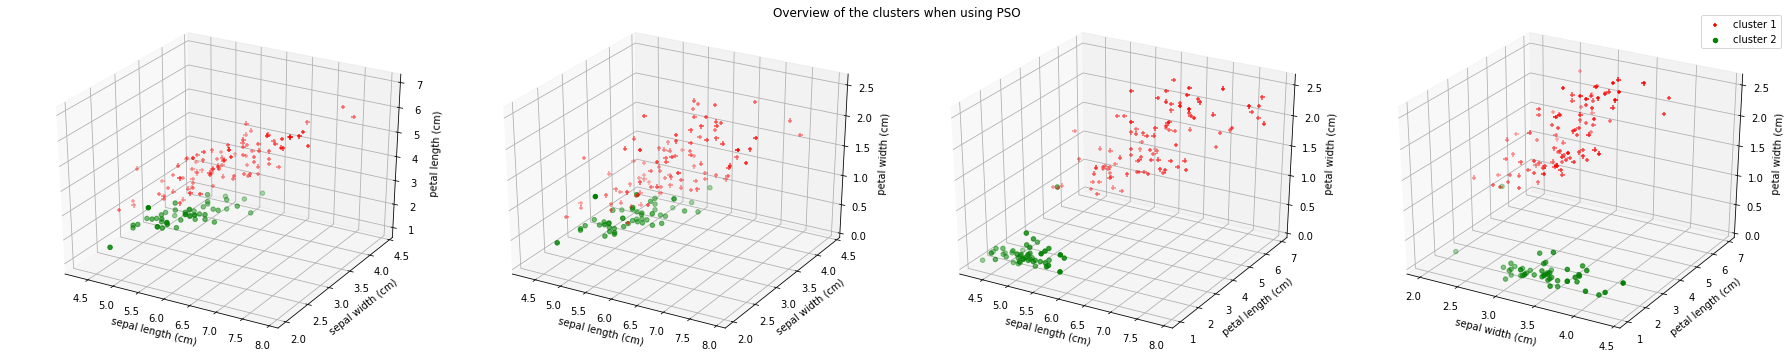

In [16]:
# Plot clusters obtained using PSO
plot_3d_cluster(iris.feature_names, PSO_clusters, 'PSO')

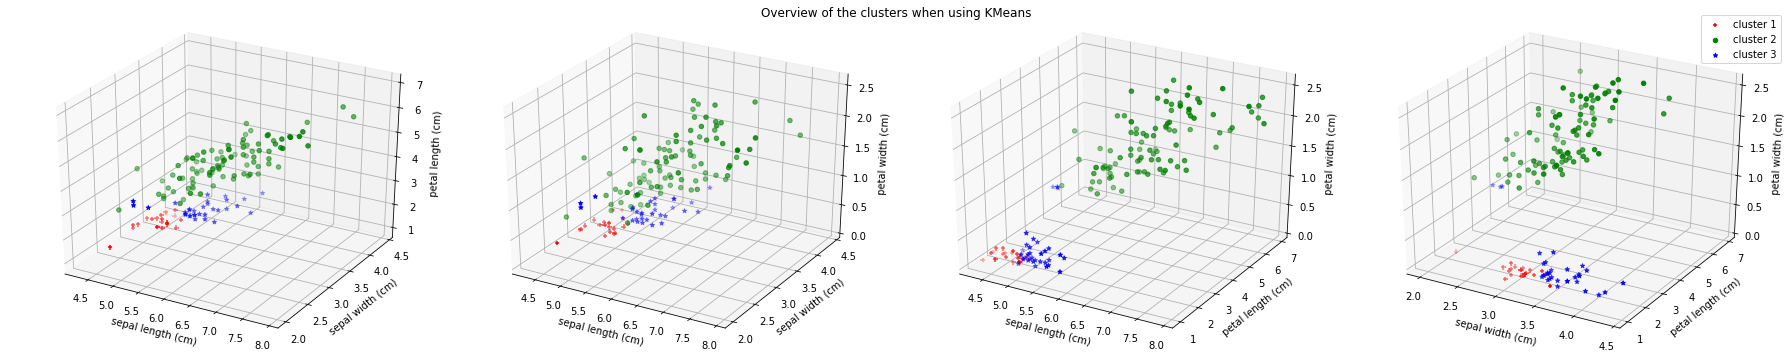

In [17]:
# Plot clusters obtained using K-means
plot_3d_cluster(iris.feature_names, KMeans_clusters, 'KMeans')

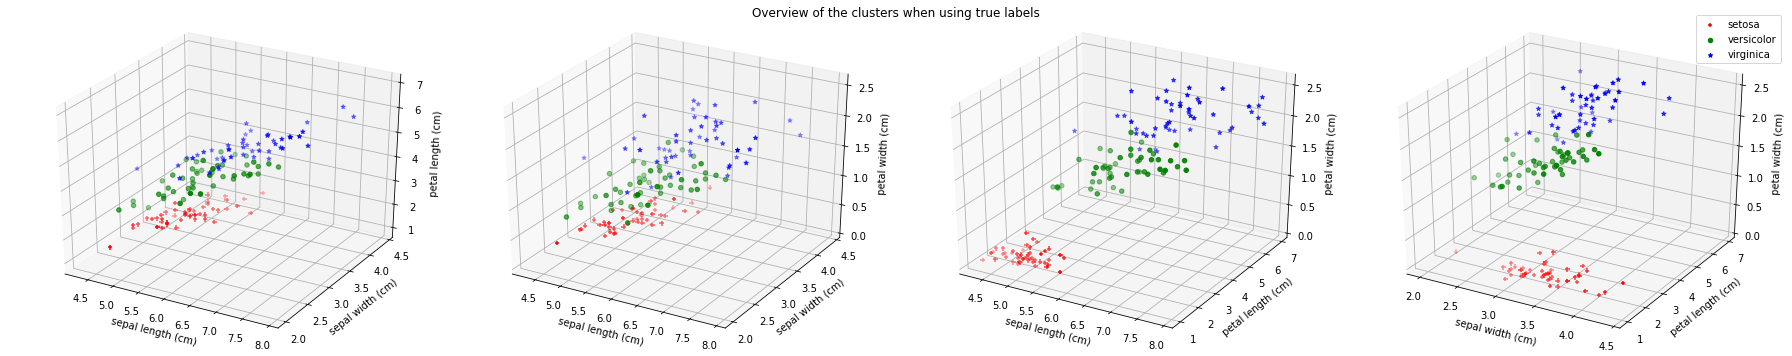

In [18]:
# Plot clusters obtained using the true labels
plot_3d_cluster(iris.feature_names, true_clusters, 'true labels', iris.target_names)